In [1]:
import random

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

random.seed(42)

In [2]:
with open('CTR.txt', 'r') as f:
    data = pd.read_csv(f, sep=":", header=None, index_col=0)
    context_features = np.array([line.split(";") for line in data.iloc[:, 0]], dtype=np.float32)
    action_rewards = np.array([line.split(";") for line in data.iloc[:, 1]], dtype=np.float32)
    
N = context_features.shape[0]
N_RUNS = 10 # for random strategy

In [3]:
def cummean(arr):
    return (np.cumsum(arr) / np.arange(1, 1 + arr.shape[0]))

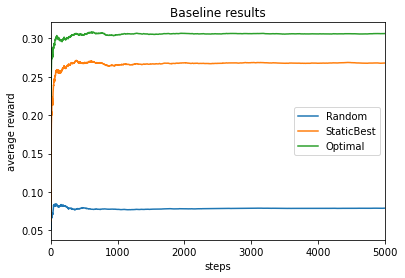

In [4]:
# Random strategy
def random_strategy(action_rewards, seed=0):
    np.random.seed(seed)
    rewards = []
    actions = []
    for i in range(N):
        act = np.random.randint(10)
        actions.append(act)
        rewards.append(action_rewards[i, act])
    return np.array(rewards), np.array(actions)

# StaticBest strategy
def staticbest_strategy(action_rewards):
    best_actions = np.argmax(np.mean(action_rewards, axis=0))
    return action_rewards[:, best_actions], best_actions

# Optimal Strategy
def optimal_strategy(action_rewards):
    return np.max(action_rewards, axis=1), np.argmax(action_rewards, axis=1)
        
# Run experiments and plot results
fig, ax = plt.subplots()

random_rewards = []
for _ in range(N_RUNS):
    rewards, _ = random_strategy(action_rewards, seed=random.randrange(2**32 - 1))
    random_rewards.append(rewards)
random_rewards = np.array(random_rewards)
random_rewards = np.mean(random_rewards, axis=0)
ax.plot(np.arange(N), cummean(random_rewards), label='Random')

staticbest_rewards, _ = staticbest_strategy(action_rewards)
ax.plot(np.arange(N), cummean(staticbest_rewards), label='StaticBest')

optimal_rewards, _ = optimal_strategy(action_rewards)
ax.plot(np.arange(N), cummean(optimal_rewards), label='Optimal')

ax.set_title('Baseline results')
ax.set_xlabel('steps')
ax.set_ylabel('average reward')
ax.legend(loc="best")
ax.set_xlim([0, N]);

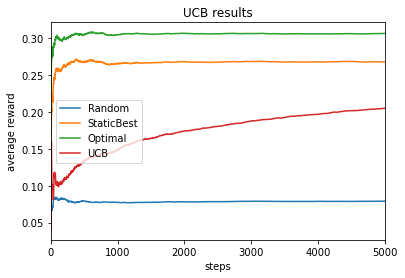

In [5]:
# UCB strategy
def ucb_strategy(action_rewards):
    num_actions = action_rewards.shape[1]
    max_reward = np.max(action_rewards)
    
    # Initialize UCB variables
    action_counter = [0] * num_actions
    values = np.array([max_reward] * num_actions) # optimistic Q values initialization
    uncertainities = np.array([max_reward] * num_actions)
    
    # Run on data
    rewards = []
    actions = []
    for t in range(N):
        # make decision
        upper_bounds = values + uncertainities
        act = np.argmax(upper_bounds)
        reward = action_rewards[t, act]
        
        # update Q values and uncertainities
        prev_count = action_counter[act]
        values[act] = (prev_count * values[act] + reward) / (prev_count + 1)
        action_counter[act] += 1
        uncertainities[act] = np.sqrt(2 * np.log(t + 1) / action_counter[act])
        
        # add decision and reward to history
        actions.append(act)
        rewards.append(reward)
        
    return np.array(rewards), np.array(actions)

ucb_rewards, ucb_actions = ucb_strategy(action_rewards)

fig, ax = plt.subplots()

ax.plot(np.arange(N), cummean(random_rewards), label='Random')
ax.plot(np.arange(N), cummean(staticbest_rewards), label='StaticBest')
ax.plot(np.arange(N), cummean(optimal_rewards), label='Optimal')
ax.plot(np.arange(N), cummean(ucb_rewards), label='UCB')

ax.set_title('UCB results')
ax.set_xlabel('steps')
ax.set_ylabel('average reward')
ax.legend(loc="best")
ax.set_xlim([0, N]);

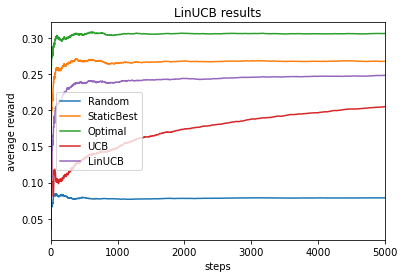

In [6]:
# LinUCB strategy
def linucb_strategy(action_rewards, context_features, alpha=0.1):
    num_actions = action_rewards.shape[1]
    context_dim = context_features.shape[1]
    
    # Initialize parameters
    W_inv = [np.identity(context_dim) for _ in range(num_actions)]
    b = [np.zeros(context_dim) for _ in range(num_actions)]
    
    # Run on data
    actions = []
    rewards = []
    p = np.zeros(num_actions)
    for t in range(N):
        # make decision
        x = context_features[t]
        for a in range(num_actions):
            theta_a = W_inv[a] @ b[a]
            p[a] = theta_a.T @ x + alpha * np.sqrt(x.T @ W_inv[a] @ x)
        act = np.argmax(p)
        reward = action_rewards[t, act]
        
        # update parameters
        W_act = np.linalg.inv(W_inv[act])
        W_act = W_act + x @ x.T
        W_inv[act] = np.linalg.inv(W_act)
        b[act] = b[act] + reward * x
        
        # add decision and reward to history
        actions.append(act)
        rewards.append(reward)
        
    return np.array(rewards), np.array(actions)

linucb_rewards, linucb_actions = linucb_strategy(action_rewards, context_features)

fig, ax = plt.subplots()

ax.plot(np.arange(N), cummean(random_rewards), label='Random')
ax.plot(np.arange(N), cummean(staticbest_rewards), label='StaticBest')
ax.plot(np.arange(N), cummean(optimal_rewards), label='Optimal')
ax.plot(np.arange(N), cummean(ucb_rewards), label='UCB')
ax.plot(np.arange(N), cummean(linucb_rewards), label='LinUCB')

ax.set_title('LinUCB results')
ax.set_xlabel('steps')
ax.set_ylabel('average reward')
ax.legend(loc="best")
ax.set_xlim([0, N]);

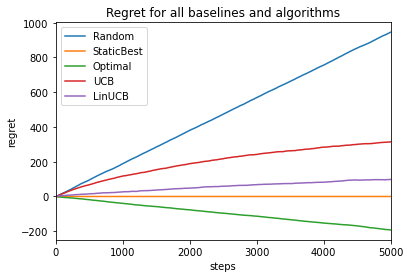

In [7]:
# Plot Regret
random_regret = np.cumsum(staticbest_rewards - random_rewards)
staticbest_regret = np.zeros_like(random_regret)
optimal_regret = np.cumsum(staticbest_rewards - optimal_rewards)
ucb_regret = np.cumsum(staticbest_rewards - ucb_rewards)
linucb_regret = np.cumsum(staticbest_rewards - linucb_rewards)

fig, ax = plt.subplots()

ax.plot(np.arange(N), random_regret, label='Random')
ax.plot(np.arange(N), staticbest_regret, label='StaticBest')
ax.plot(np.arange(N), optimal_regret, label='Optimal')
ax.plot(np.arange(N), ucb_regret, label='UCB')
ax.plot(np.arange(N), linucb_regret, label='LinUCB')

ax.set_title('Regret for all baselines and algorithms')
ax.set_xlabel('steps')
ax.set_ylabel('regret')
ax.legend(loc="best")
ax.set_xlim([0, N]);